In [1]:
library(reshape2)
library(corrplot)
library(stringr)
library(qvalue)

corrplot 0.84 loaded


In [1]:
geneinfo = read.table("/publicdata/gencode_v19_20151104/gene_info.tsv", sep = "\t", header = T)

In [14]:
skin_cells = data.frame(celltypes = c("gt", "gt:epidermal", "gt:keratinocyte_stem_cell", "gt:leucocyte", "gt:epidermal_stem_cell"),
                       name      = c("bulk", "epidermal_cancer_OR"     , "keratinocyte_stem_cell_cancer_OR", "leucocyte_cancer_OR", "epidermal_stem_cell_cancer_OR"   ),
                       name.fixed      = c("bulk", "epidermal"     , "keratinocyte_stem_cell", "leucocyte", "epidermal_stem_cell"   ),
                       color     = c("#7f7e7e", "#38ace2"       , "#a084bd"               , "#f067a1"  , "#e38725"               ))

# Combine coloc results

In [4]:
egenes = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/private/coloc/egenes.txt", header = T)
egenes_liver = egenes[egenes$main == "liver", "gene_id"]
egenes_skin  = egenes[egenes$main == "skin" , "gene_id"]

In [5]:
ReadColocResults <- function(x){
    
    file = paste(path2coloc, x, ".txt", sep = "")
    
    if(file.exists(file)){
        
        info = file.info(file)

        if (info$size > 0){
            read.table(file, header = T)        
        }
    }
}

In [6]:
path2coloc = "/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/private/coloc/liver/"
liver.coloc = do.call("rbind", lapply(egenes_liver, ReadColocResults))

In [7]:
liver.coloc.ordered = liver.coloc[order(-liver.coloc$PP.H4.abf), ]

In [7]:
write.table(liver.coloc.ordered, file = "../tables/coloc_liver_results.txt", quote = T, row.names = F)

In [8]:
path2coloc = "/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/private/coloc/skin/"
skin.coloc = do.call("rbind", lapply(egenes_skin, ReadColocResults))

In [9]:
skin.coloc.ordered = skin.coloc[order(-skin.coloc$PP.H4.abf), ]

In [63]:
write.table(skin.coloc.ordered, file = "../tables/coloc_skin_results.txt", quote = T, row.names = F)

# Skin

In [6]:
skin.gwas = read.csv("../tables/skin_gwas.csv", header = T)
skin_mouse_eqtl = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/skin_cells/analysis/lmm_compare_fdr.skin_cells.txt", header = T)

In [10]:
skin.coloc.ordered = skin.coloc[order(-skin.coloc$PP.H4.abf), ]
skin.coloc.ordered$gwas = skin.gwas[match(skin.coloc.ordered$id2, skin.gwas$Phenotype.Code	), "Phenotype.Description"]
# skin.coloc.ordered$eqtl = skin_mouse_eqtl[match(skin.coloc.ordered$gene_id, skin_mouse_eqtl$gene_id), "best"]

#### Collapse skin GWAS

In [24]:
collapsed = data.frame(gwas = unique(skin.coloc.ordered$gwas), collapsed_trait = c("malignant_neoplasm", "malignant_neoplasm", "malignant_neoplasm", "melanoma", "melanoma",
                                                                                   "infections", "infections", "ulcers", "cancer", "congenital",
                                                                                   "infections", "unspecified", "infections", "melanoma", "melanoma", "infections", "infections",
                                                                                   "unspecified", "infections", "cancer", "infections" ))

In [25]:
skin.coloc.ordered$gwas_collapsed = collapsed[match(skin.coloc.ordered$gwas, collapsed$gwas), "collapsed_trait"]

#### add cell type pvalues for each eGene

In [26]:
for( celltype in colnames(skin_mouse_eqtl[, grep(".qval", colnames(skin_mouse_eqtl))])){

    cell =  str_split_fixed(celltype, "\\.", 3)[,2]
    skin.coloc.ordered[, cell] = skin_mouse_eqtl[match(skin.coloc.ordered$gene_id, skin_mouse_eqtl$gene_id), celltype]

}

skin.coloc.ordered$bulk <- apply(skin.coloc.ordered[, c((ncol(skin.coloc.ordered) - 3) : (ncol(skin.coloc.ordered)))], 1, function(x) sum(x< 0.05))

In [27]:
skin.coloc.ordered = skin.coloc.ordered[skin.coloc.ordered$id1 == "skin_cells", ]

In [23]:
write.table(skin.coloc.ordered, file = "../tables/skin_coloc_formatted.txt", quote = F, row.names = F, sep = "\t")

In [1302]:
# skin.coloc.ordered$cell_type_specific <- skin.coloc.ordered$bulk

# Is given cell type enriched for colocalizing with a given study?

In [60]:
QvalueCol <- function(x){
    
    return(qvalue(x)$qvalues)
    
}

In [61]:
CalculateEnrichmentCTS <- function(cell, study, H0){


    skin.coloc.ordered_temp = skin.coloc.ordered[ skin.coloc.ordered[, "gwas_collapsed"] == study, ]
#     skin.coloc.ordered_temp = skin.coloc.ordered[ skin.coloc.ordered[, "id2"] == study, ]

    all   = skin.coloc.ordered_temp$gene_id
    
    if(! cell == "bulk"){
        cts.t = skin.coloc.ordered_temp[  skin.coloc.ordered_temp[, cell] < 0.05 & skin.coloc.ordered_temp$bulk == 1, "gene_id"]
        cts.f = skin.coloc.ordered_temp[! (skin.coloc.ordered_temp[, cell] < 0.05 & skin.coloc.ordered_temp$bulk == 1), "gene_id"]
    }

    if(cell == "bulk"){
        cts.t = skin.coloc.ordered_temp[  skin.coloc.ordered_temp[, cell] < 0.05, "gene_id"]
        cts.f = skin.coloc.ordered_temp[! (skin.coloc.ordered_temp[, cell] < 0.05), "gene_id"]
    }

    
    colocalizes.T = skin.coloc.ordered_temp[  skin.coloc.ordered_temp$PP.H4.abf > H0, "gene_id"]
    colocalizes.F = skin.coloc.ordered_temp[! skin.coloc.ordered_temp$PP.H4.abf > H0, "gene_id"]



    A = length(all[all %in% cts.t &
            all %in% colocalizes.T])

    B = length(all[all %in% cts.t &
            all %in% colocalizes.F])

    C = length(all[all %in% cts.f &
            all %in% colocalizes.T])

    D = length(all[all %in% cts.f &
            all %in% colocalizes.F])


    OR = (A * D) / (B * C)
    
    p = fisher.test(matrix(c(A, B, C, D), byrow = TRUE, 2, 2))$p.value

    return(c(OR, p))
}

In [71]:
CalculateEnrichment <- function(cell, study, H0){


    skin.coloc.ordered_temp = skin.coloc.ordered[ skin.coloc.ordered[, "gwas_collapsed"] == study, ]
#     skin.coloc.ordered_temp = skin.coloc.ordered[ skin.coloc.ordered[, "id2"] == study, ]

    all   = skin.coloc.ordered_temp$gene_id
    

    cts.t = skin.coloc.ordered_temp[  skin.coloc.ordered_temp[, cell] < 0.05, "gene_id"]
    cts.f = skin.coloc.ordered_temp[! (skin.coloc.ordered_temp[, cell] < 0.05), "gene_id"]

    
    colocalizes.T = skin.coloc.ordered_temp[  skin.coloc.ordered_temp$PP.H4.abf + skin.coloc.ordered_temp$PP.H3.abf > H0, "gene_id"]
    colocalizes.F = skin.coloc.ordered_temp[! skin.coloc.ordered_temp$PP.H4.abf + skin.coloc.ordered_temp$PP.H3.abf> H0, "gene_id"]



    A = length(all[all %in% cts.t &
            all %in% colocalizes.T])

    B = length(all[all %in% cts.t &
            all %in% colocalizes.F])

    C = length(all[all %in% cts.f &
            all %in% colocalizes.T])

    D = length(all[all %in% cts.f &
            all %in% colocalizes.F])


    OR = (A * D) / (B * C)
    
    p = fisher.test(matrix(c(A, B, C, D), byrow = TRUE, 2, 2))$p.value

    return(c(OR, p))
}

In [63]:
PlotORs <- function(df, cell, study){

    
    plot(df[, 1], log(df[, 2]), ylim = c(-5, 5), pch = 20, las = 1, ylab = "log(OR)", xlab = "H4", main = paste(study, " ~ ", cell))
    
}


In [64]:
ORWrapper <- function(cell, study, H){

    ORs = c()
    Ps = c()
    
    for( H0 in H){

#         enrichment = CalculateEnrichmentCTS(cell, study, H0)
        enrichment = CalculateEnrichment(cell, study, H0)
        ORs = c(ORs, enrichment[1])
        Ps  = c(Ps, enrichment[2])
    }

    OR.df = data.frame(H0 = H, temp = ORs, tempp = Ps)
    
    names(OR.df)[names(OR.df) == "temp"] <- paste(cell, study, "OR", sep = ".")
    names(OR.df)[names(OR.df) == "tempp"] <- paste(cell, study, "P.value", sep = ".")
    
#     PlotORs(OR.df, cell, study)
    
    return(OR.df)

}

In [65]:
figure_width  =  8
figure_height = 8
options(repr.plot.width = figure_width, repr.plot.height = figure_height)
par(mfrow = c(4,4))

celltypes = str_split_fixed(colnames(skin_mouse_eqtl[, grep(".qval", colnames(skin_mouse_eqtl))]), "\\.", 3)[, 2]
celltypes <- c(celltypes, "bulk")

H0 = seq(0, 1, by = 0.05)

cell.OR.df = data.frame(H0, fake = H0)

for(cell in celltypes){

#     for( study in unique(skin.coloc.ordered$id2)){
    for( study in unique(skin.coloc.ordered$gwas_collapsed)){
        

        cell.OR.df = merge(cell.OR.df, ORWrapper(cell, study, H0))
        
    }
}

In [2]:
figure_width  =  8
figure_height = 8
options(repr.plot.width = figure_width, repr.plot.height = figure_height)


H0 = seq(0, 1, by = 0.05)
pch.sig = data.frame(Significant = c(TRUE, FALSE), pch = c(16, 1), cex = c(4, 3))

for( study in unique(skin.coloc.ordered$gwas_collapsed)){

    study_cells = cell.OR.df[, grep(study, colnames(cell.OR.df))]
    
    study_cells.or = study_cells[, grep("OR", colnames(study_cells))]
    study_cells.p = study_cells[, grep("P.value", colnames(study_cells))]

    study_cells.p[study_cells.p > 1]<-.9999999999999999999999999999999
    study_cells.p = apply(study_cells.p, 2, QvalueCol)

    
    plot(1, type="n", xlim=c(0, 1), ylim=c(-4, 4.75), las = 1, ylab = "log(OR)", xlab = "H4", main = paste(study))
    
    abline(h = 0)
    for(cell in colnames(study_cells.or)){

        ct = str_split_fixed(cell, "\\.", 3)[,1]

        lines(H0, log(study_cells.or[, cell]), col = skin_cells[skin_cells$name.fixed == ct, "color" ], lwd = 9)

        points(H0, log(study_cells.or[, cell]), col = paste(skin_cells[skin_cells$name.fixed == ct, "color" ], "99", sep = ""),
               pch = pch.sig[match(study_cells.p[, grep(ct, colnames(study_cells.p))] < 0.05, pch.sig$Significant), "pch"],
               cex = pch.sig[match(study_cells.p[, grep(ct, colnames(study_cells.p))] < 0.05, pch.sig$Significant), "cex"],
               lwd = 4)
    }

}


# Examples

In [3]:
mouse_skin = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/skin_cells/analysis/lmm_compare.skin_cells.txt", header = T)

In [4]:
id = "ENSG00000137310.7"

In [5]:
mouse_skin = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/skin_cells/analysis/lmm_compare.skin_cells.txt", header = T)

In [6]:
snp = mouse_skin[mouse_skin$gene_id == id, "id"]

In [7]:
gt = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/input/genotypes/rna/gt_data.ENSG00000137310.7.txt", check.names = F, header = T)

In [8]:
pt = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/input/phenotypes/skin/ENSG00000137310.7.txt", header = T)

In [9]:
meta = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/input/metadata/metadata.txt", header = T)

In [10]:
pt$name <- meta[match(pt$sample_id, meta$rna_id), "subject_id"]

In [11]:
betas = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/skin_cells/analysis/beta.txt", header = T)

In [12]:
x = as.data.frame(t(gt[snp, ]))
x$name = rownames(x)

plot = merge(pt, x)
plot$gt = plot[, 5]

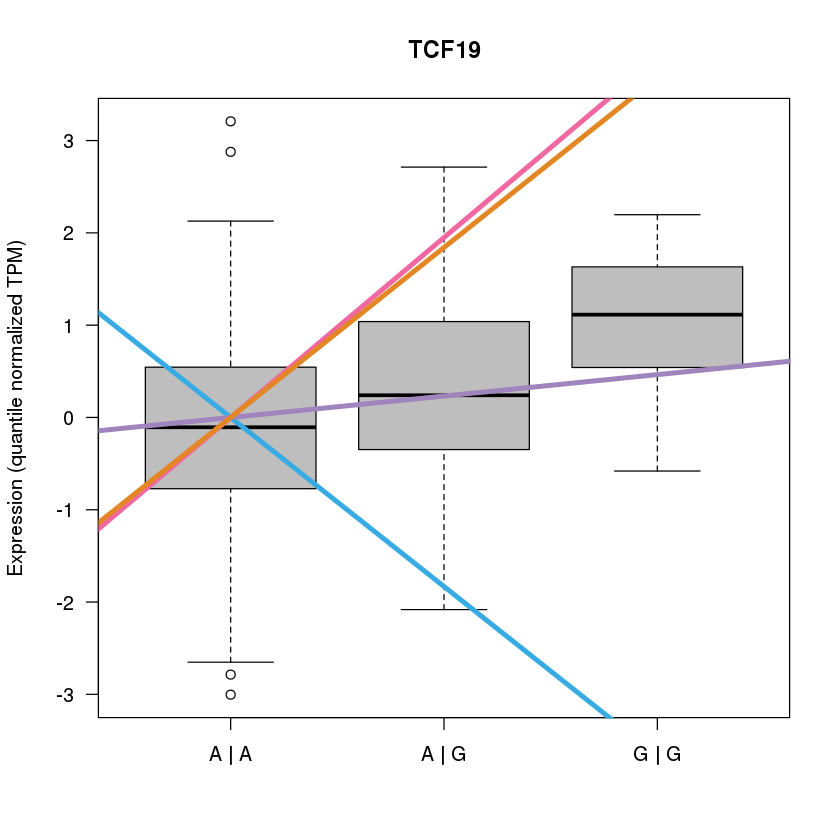

In [15]:
boxplot(norm~gt, data=plot, main = "TCF19", ylab = "Expression (quantile normalized TPM)", las = 1,
        names = c("A | A", "A | G", "G | G"), col = "grey", at = c(0, 1, 2),
        width = c(0.25, 0.25, 0.25)) #, ylim = c(-10, 10))




for(celltype in unique(betas[betas$gene_name == "TCF19", "var1"])){
    
    b = betas[betas$var1 == celltype, "beta"][1]
    color = skin_cells[skin_cells$celltypes == celltype, "color"]
    abline(0, b, lwd = 4, col = color)   
}

In [16]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS: /frazer01/home/matteo/software/R-3.5.1/lib/libRblas.so
LAPACK: /frazer01/home/matteo/software/R-3.5.1/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_3.5.1  IRdisplay_0.7.0 pbdZMQ_0.3-3    tools_3.5.1    
 [5] htmltools_0.3.6 pillar_1.4.1    base64enc_0.1-3 crayon_1.3.4   
 [9] Rcpp_1.0.1      uuid_0.1-2      IRkernel_1.0.1  jsonlite_1.6   
[13] digest_0.6.19   repr_1.0.